# A simple binary problem: is there a legal move or not?

This is a simplified version in which the model only answers the question whether there is at least one legal move or not.

In [ ]:
from MorpionSolitaire import *
from DeepLearningMS import *

In [ ]:
from multiprocess import Pool
pool = Pool()

## Data generation

This function plays one game at random until there are no more moves, stores the grid as `grid1`, then rewinds the game to an interemediate stage, and stores the resulting grid as `grid2`. The output of the function is a tensor containing the two grids. By construction the first grid has no legal moves and the second one has at least one legal move.

1/3 of the time the game is taken back to an arbitrary intermediate step.
The other 2/3 of the time we rewind the game by only one step, so that the network gets used to identify a single allowed move. If we did not do that the training process would result in a relatively high accuracy by only identifying some types of allowed moves instead of all of them.

In [ ]:
def play_one_game(host = 0): # dummy argument needed for passing to pool.map
    game = NewGame('cross').play()
    grid1 = game.grid.image()
    if np.random.randint(3) == 0:
        game = game.unplay(np.random.randint(game.score - 1) + 2)
    else:
        game = game.unplay(1)
    grid2 = game.grid.image()
    return np.stack((grid1, grid2))

Mini-batches contains a certain number of grids obtained in the way described above (computed in parallel to gain time), as well as a labels (0 for no legal moves, 1 for at least one legal move).

In [ ]:
def generate_batch(batch_size = 100):
    x = torch.tensor(np.concatenate(pool.map(play_one_game, range(batch_size // 2)))).float().unsqueeze(1)
    y = torch.tensor([0.,1.]).repeat(batch_size // 2).unsqueeze(1)
    return x, y

In [ ]:
# def generate_batch(batch_size = 100):
#     x = []
#     for _ in range(batch_size // 2):
#         x.append(play_one_game())
#     x = torch.tensor(np.concatenate(x)).float().unsqueeze(1)
#     y = torch.tensor([0.,1.]).repeat(batch_size // 2).unsqueeze(1)
#     return x, y

20,000 grids and labels computed in this way are saved once and for all:

In [ ]:
# grids = np.concatenate(pool.map(play_one_game, range(10000)))
# np.save('data/simple_problem_grids.npy', grids)
# grids.shape

In [ ]:
# labels = np.zeros(20000, dtype=bool)
# labels[1::2] = True
# np.save('data/simple_problem_labels.npy', labels)
# labels.shape

## Data frame

In [ ]:
# data = MSDataFrame(generate_batch, repeat = 1000, length = 200)
# data.info()

In [ ]:
data = MSDataFrame(batch_size = 200, length = 100,
                   batch_fct = generate_batch, repeat = 16,
                   data = 'data/simple_problem_grids.npy',
                   labels = 'data/simple_problem_labels.npy')
data.info()

Number of mini-batches stored: 100
Number of mini-batches created: 0


In [ ]:
x, y = data.data[0]

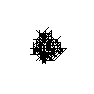

In [ ]:
MSvisualize(x[0])

In [ ]:
y[0]

tensor([0.])

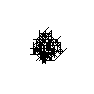

In [ ]:
MSvisualize(x[1])

In [ ]:
y[1]

tensor([1.])

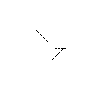

In [ ]:
MSvisualize(x[1]-x[0])

## Accuracy function

In [ ]:
def accuracy(outputs, labels):
    return ((outputs > 0.5) == labels).float().mean()

## Model

In [ ]:
# net = torch.nn.Sequential(
#     torch.nn.Conv2d(1, 5, stride = 3, kernel_size = 3, padding = 1, bias = False), # output 32 x 32 pixels
#     torch.nn.Conv2d(5, 40, stride = 1, kernel_size = 5, padding = 2), # output 32 x 32 pixels
#     torch.nn.ReLU(),
#     torch.nn.Conv2d(40, 10, stride = 1, kernel_size = 1, padding = 0), # output 32 x 32 pixels
#     torch.nn.AdaptiveMaxPool2d(1),
#     torch.nn.Flatten(),
#     torch.nn.Linear(10, 3),
#     torch.nn.ReLU(),
#     torch.nn.Linear(3, 1)
# )

Set the first layer to be non-trainable, and initialize to nice values:

In [ ]:
# for param in net.parameters():
#     firstlayer = param
#     break
# firstlayer.requires_grad = False
# for c in range(5):
#     firstlayer[c,0] = torch.zeros(3,3)
# firstlayer[0,0,1,1] = 1.0
# firstlayer[1,0,0,1] = 1.0
# firstlayer[2,0,1,0] = 1.0
# firstlayer[3,0,0,0] = 1.0
# firstlayer[4,0,0,2] = 1.0
# firstlayer

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 20, stride = 3, kernel_size = 3, padding = 1), # output 32 x 32 pixels
    torch.nn.ReLU(),
    torch.nn.Conv2d(20, 40, stride = 1, kernel_size = 2, padding = 0), # output 31 x 31 pixels
    torch.nn.ReLU(),
    torch.nn.Conv2d(40, 40, stride = 1, kernel_size = 2, padding = 0), # output 30 x 30 pixels
    torch.nn.ReLU(),
    torch.nn.Conv2d(40, 40, stride = 1, kernel_size = 2, padding = 0), # output 29 x 29 pixels
    torch.nn.ReLU(),
    torch.nn.Conv2d(40, 10, stride = 1, kernel_size = 2, padding = 0), # output 28 x 28 pixels
    torch.nn.AdaptiveMaxPool2d(1),
    torch.nn.Flatten(),
    torch.nn.Linear(10, 3),
    torch.nn.ReLU(),
    torch.nn.Linear(3, 1)
)

In [ ]:
y_pred = net(x)
y_pred.shape

torch.Size([200, 1])

In [ ]:
accuracy(y_pred, y)

tensor(0.5000)

## Training

In [ ]:
running_loss_data = []
accuracy_data = []

In [ ]:
data.train_model(net, n_epochs = 200, lr=0.01, accuracy_func = accuracy,
                 loss_monitoring = running_loss_data,
                 accuracy_monitoring = accuracy_data)

/home/marc/anaconda3/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


[0]  loss: 0.318   accuracy: 0.50
[1]  loss: 0.250   accuracy: 0.51
[2]  loss: 0.250   accuracy: 0.57
[3]  loss: 0.250   accuracy: 0.58
[4]  loss: 0.250   accuracy: 0.58
[5]  loss: 0.250   accuracy: 0.58
[6]  loss: 0.249   accuracy: 0.58
[7]  loss: 0.249   accuracy: 0.58
[8]  loss: 0.248   accuracy: 0.57
[9]  loss: 0.245   accuracy: 0.57
[10]  loss: 0.241   accuracy: 0.57
[11]  loss: 0.240   accuracy: 0.58
[12]  loss: 0.239   accuracy: 0.58
[13]  loss: 0.239   accuracy: 0.58
[14]  loss: 0.239   accuracy: 0.57
[15]  loss: 0.238   accuracy: 0.57
[16]  loss: 0.238   accuracy: 0.57
[17]  loss: 0.236   accuracy: 0.57
[18]  loss: 0.233   accuracy: 0.58
[19]  loss: 0.231   accuracy: 0.58
[20]  loss: 0.230   accuracy: 0.59
[21]  loss: 0.229   accuracy: 0.59
[22]  loss: 0.230   accuracy: 0.59
[23]  loss: 0.227   accuracy: 0.60
[24]  loss: 0.228   accuracy: 0.59
[25]  loss: 0.226   accuracy: 0.60
[26]  loss: 0.228   accuracy: 0.59
[27]  loss: 0.226   accuracy: 0.60
[28]  loss: 0.227   accuracy: 

In [ ]:
# torch.save(net, 'models/Descartes.pt')

In [ ]:
data.info()

Number of mini-batches stored: 100
Number of mini-batches created: 1248


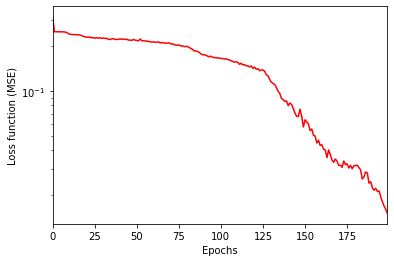

In [ ]:
plt.plot(running_loss_data, color='red')
plt.xlabel('Epochs')
plt.xlim(0, 199)
plt.ylabel('Loss function (MSE)')
plt.yscale('log')
# plt.savefig('Democritus_loss.png', bbox_inches='tight')
plt.show()

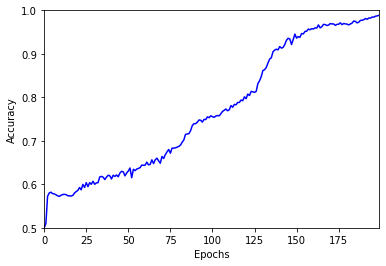

In [ ]:
plt.plot(accuracy_data, color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim(0, 199)
plt.ylim(0.5, 1)
# plt.savefig('Democritus_accuracy.png', bbox_inches='tight')
plt.show()

In [ ]:
error_data = [1.0 - x for x in accuracy_data]

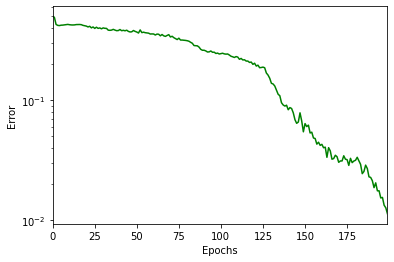

In [ ]:
plt.plot(error_data, color='green')
plt.xlabel('Epochs')
plt.xlim(0, 199)
plt.ylabel('Error')
plt.yscale('log')
plt.show()

## Loading the model

Once the model has been trained, this can be used to load its state dictionary:

In [ ]:
net2 = torch.load('models/Descartes.pt')
net2.eval()

Sequential(
  (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(20, 40, kernel_size=(2, 2), stride=(1, 1))
  (3): ReLU()
  (4): Conv2d(40, 40, kernel_size=(2, 2), stride=(1, 1))
  (5): ReLU()
  (6): Conv2d(40, 40, kernel_size=(2, 2), stride=(1, 1))
  (7): ReLU()
  (8): Conv2d(40, 10, kernel_size=(2, 2), stride=(1, 1))
  (9): AdaptiveMaxPool2d(output_size=1)
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=10, out_features=3, bias=True)
  (12): ReLU()
  (13): Linear(in_features=3, out_features=1, bias=True)
)

## Validation

In [ ]:
x, y = generate_batch(1000)

In [ ]:
y_preds = net2(x).data

In [ ]:
accuracy(y_preds, y)

tensor(0.9890)

In [ ]:
y.mean(), y.std(), y_preds.mean(), y_preds.std()

(tensor(0.5000), tensor(0.5003), tensor(0.4742), tensor(0.4563))

In [ ]:
mistakes = []
for i in range(y.shape[0]):
    if (y_preds[i] > 0.5) != y[i]:
        mistakes.append([i, y[i].item(), y_preds[i].item()])
mistakes

[[35, 1.0, 0.14153707027435303],
 [135, 1.0, 0.38496291637420654],
 [285, 1.0, 0.38496291637420654],
 [338, 0.0, 0.8244150280952454],
 [454, 0.0, 0.8483152389526367],
 [509, 1.0, 0.28739964962005615],
 [552, 0.0, 0.8244150280952454],
 [606, 0.0, 0.8483152389526367],
 [683, 1.0, 0.0024511723313480616],
 [820, 0.0, 0.8483152389526367],
 [853, 1.0, 0.28739964962005615],
 [983, 1.0, 0.4784999489784241]]

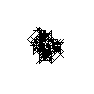

In [ ]:
MSvisualize(x[mistakes[0][0]])

## Remarks

- It is crucial to use dynamical data here, otherwise the model finds a way of overfitting the training data. With 20,000 grids, after fitting to 99% accuracy in 200 epochs, the validation only gives 92% accuracy. This shows that while the model found some features, it also overfitted the data.